## Clustering and Classification of MEPs' Tweets - Applied Machine Learning 
### 3rd Assignment
### Fall Semester 2019-2020
***
> Nikolaos Fragkomanolis AM: 8160142 <br />
> Athens University of Economics and Business 17/12/2019 <br />

At first, we import the necessary libs in order to proceed with the analysis

In [488]:
import pandas as pd
import tweepy
import sklearn as sk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA
import seaborn as sns

## 1. Data Preparation </br>
We read our *retweet.csv* file that contains all the necessary data we need. We print a sample of the data in order to understand what it contains. We also visit the [Readme](https://www.clarin.si/repository/xmlui/bitstream/handle/11356/1071/Readme.txt?sequence=8&isAllowed=y) file in order to find the true meaning of each column.

In [103]:
data_filename = 'retweets.csv'
data = pd.read_csv(data_filename)
print(len(data))
data.head()

26133


,origUserId,origUserScreenName,origMepId,origMepName,origMepGroupId,origMepGroupShort,origMepCountryId,origMepCountryShort,retweetUserId,retweetUserScreenName,...,retweetMepName,retweetMepGroupId,retweetMepGroupShort,retweetMepCountryId,retweetMepCountryShort,origCreatedAt,origTweetId,retweetCreatedAt,retweetTweetId,lang
0,249601317,papadimoulis,28586,Dimitrios PAPADIMOULIS,0,GUE-NGL,11,GRC,33248043,EvaKaili,...,Eva KAILI,1,S&D,11,GRC,Tue Nov 01 12:11:39 +0000 2011,131342637201506304,Sat Jun 27 14:17:28 +0000 2015,614799711309012992,el
1,249601317,papadimoulis,28586,Dimitrios PAPADIMOULIS,0,GUE-NGL,11,GRC,33248043,EvaKaili,...,Eva KAILI,1,S&D,11,GRC,Sun Feb 05 07:45:30 +0000 2012,166064894725206017,Wed Jun 17 12:04:06 +0000 2015,611142270809731072,el
2,217749896,MLP_officiel,28210,Marine LE PEN,7,ENL,9,FRA,498983436,SteeveBriois,...,Steeve BRIOIS,7,ENL,9,FRA,Sun Mar 25 14:47:16 +0000 2012,183928038675849216,Tue Nov 24 09:58:19 +0000 2015,669092676000686080,fr
3,19017675,Nigel_Farage,4525,Nigel FARAGE,6,EFDD,27,GBR,121171051,MargotLJParker,...,Margot PARKER,6,EFDD,27,GBR,Wed Jul 04 11:05:03 +0000 2012,220473289259233285,Sun Dec 07 21:46:00 +0000 2014,541710240014942209,en
4,217749896,MLP_officiel,28210,Marine LE PEN,7,ENL,9,FRA,3065992036,DominiqueBilde,...,Dominique BILDE,7,ENL,9,FRA,Wed May 15 17:43:25 +0000 2013,334725721853407232,Mon May 25 12:36:41 +0000 2015,602815550473904128,fr


We want to keep only the tweets that were posted in english. For this reason, the column *lang* helps us determine the tweets that were written in english, so we keep them.

We also remove all the duplicate values based on the `origTweetId`, as we are not interested in words that appear a lot of times just because the tweet in which it is included was retweeted several times. It is not useful for either purposes of the assignment (classification & clustering).

In [105]:
en_tweets = data[data['lang'] == 'en'].reset_index(drop=True)
en_tweets.drop_duplicates(subset=['origTweetId'], inplace=True)
print(len(en_tweets))
en_tweets.loc[:, ['origUserScreenName', 'origTweetId']].head()

10834


,origUserScreenName,origTweetId
0,Nigel_Farage,220473289259233285
1,MartinSchulz,353060776707235841
2,MartinSchulz,467647542378123264
3,Tim_Aker,471694322472353793
5,juliegirling,486509184708792320


Now we are ready to get our tweets from Tweeter API using *Tweepy*:
- We create a `Series` that contains only the orignal Tweets' ID 
- We group it by 100 records and we create `gr_ids`. That means that each group in `gr_ids` contains 100 records. This is necessary because we cannot call the relative function `API.statuses_lookup` for more than 100 elements.
- We create en empty list `tweets`, inside which we are going to store the text we are about to download.
- We run a for loop in order to get the text of the tweets for which we have their IDs.

Note: the `.extend()` method assigns each post as a single element in tweets. Otherwise (i.e. if we used `.append`), each element in tweets would contain 100 posts.

In [106]:
twitter_keys = {
    'consumer_key' : 'HusZsf4LFTL3L7XcWkvrmfB5j',
    'consumer_secret' : 'YOJSUvrXsgtkKA4Wx1gK2qnv1MwEhxVDbaJYe0SPZHcRPMdf03',
    'access_token_key' : '1204732205890703361-iXDeCPysNtJwTS1fosN5F36gRJ2tF6',
    'access_token_secret' : 'GhyPar1i99fMsxhmH0iSDiqQCVZTGKasQvLcdKtgonbmb'
}

auth = tweepy.OAuthHandler(twitter_keys['consumer_key'], twitter_keys['consumer_secret'])
auth.set_access_token(twitter_keys['access_token_key'], twitter_keys['access_token_secret'])

api = tweepy.API(auth)

ids = pd.Series(en_tweets['origTweetId'])
gr_ids = ids.groupby(ids.index//100)
tweets = []
gr_ids

for ind, gr in gr_ids:
    tweets.extend(api.statuses_lookup(gr.tolist()))

In order to validate that we indeed downloaded the texts we print a sample of the data in a readable format, using a for loop.

In [107]:
i=0
for t in tweets:
    print(t.id)
    print(t.text)
    print(i)
    print('===================================')
    i+=1
    if i == 200:
        break

519050739642286080
Lord Hill's written answers to EP are now on my blog. No transparency on his lobbying past. Shame! http://t.co/OT7TGKGDek #EPhearings2014
0
519139901359783936
Our @SebDance asks @ABratusek about global climate talks.'Pls tell us how you will push a strong &amp; unified EU voice?' http://t.co/qR484dM9m9
1
518024241024073728
I write for @LabourList Tory threat to Court of #HumanRights "would replace rule of law with rule of mob." http://t.co/79DGCT8t2E @LabourCHR
2
519109106272317440
“@Ashleyfoxmep: and named her party "the Alliance of Alenka Bratusek! #EPhearings2014 Mrs Bratusek says #Bratusek
3
518721908951769088
Good luck to @TheProgressives in Bulgaria today @EuroLabour
4
517735072754302976
As EP does not provide coffee in meetings Commissioner designate Vestager has invited us for it. We'll approve her  #Vestager #EPHearing2014
5
500600838419935232
Robert Halfon raising issue of illegal traveller sites - if UKIP had done it he'd have called us Nazis http://t.co/r

We merge the data we obtained with their IDs and create a pandas DataFrame.

In [108]:
tweets_txt = pd.DataFrame({"origTweetId" : [t.id for t in tweets],
                           "origTweetTxt" : [t.text for t in tweets]})
print(len(tweets_txt))
tweets_txt.head()

10126


,origTweetId,origTweetTxt
0,519050739642286080,Lord Hill's written answers to EP are now on m...
1,519139901359783936,Our @SebDance asks @ABratusek about global cli...
2,518024241024073728,I write for @LabourList Tory threat to Court o...
3,519109106272317440,"“@Ashleyfoxmep: and named her party ""the Allia..."
4,518721908951769088,Good luck to @TheProgressives in Bulgaria toda...


We add the texts in our original Data-Frame. Now, each record contains an extra column which contains the tweet's original text.

In [109]:
MEP_tweets = pd.merge(en_tweets, tweets_txt, on='origTweetId')
print(len(MEP_tweets))
MEP_tweets.loc[:, ['origUserScreenName', 'origTweetId', 'origTweetTxt']].head()

10126


,origUserScreenName,origTweetId,origTweetTxt
0,Nigel_Farage,220473289259233285,Euro Parliament votes overwhelmingly to reject...
1,MartinSchulz,353060776707235841,"US have one currency, one Central Bank and one..."
2,MartinSchulz,467647542378123264,More jobs for young people is my top priority ...
3,Tim_Aker,471694322472353793,"Vote #Labour, get Tory. Vote Tory, get Labour...."
4,juliegirling,486509184708792320,Answering my question in ECR Group J-C Juncker...


Next, we want to exclude the records of the European groups that have very few tweets (less that 50). For this reason we count the number of times each group appears in the DataFrame. We can see that Groups 7 and 8 are considered to have a low number of tweets.

In [111]:
tweets_perMEPgroup = MEP_tweets.origMepGroupId.value_counts()
tweets_perMEPgroup

6    2419
1    2367
4    1638
3    1457
5     966
2     953
0     304
7      21
8       1
Name: origMepGroupId, dtype: int64

We create a series that contains the index of the records that have a group ID equal to the groups that have tweets lower than 50. We `drop` the relative records using their index. 

In [112]:
ind = tweets_perMEPgroup[tweets_perMEPgroup < 50].index
MEP_tweets.drop(MEP_tweets[MEP_tweets['origMepGroupId'].isin(ind)].index, inplace=True)
len(MEP_tweets)

10104

## 2. Clustering

We are going to convert our texts to a suitable format in order to use k-means clustering: 
- we replace with a single space (' ') the urls of each tweet text using `re` lib
- we bring every text to lower case

In [113]:
url = re.compile("http\S+")
MEP_tweets['origTweetTxt'] = (MEP_tweets['origTweetTxt'].apply(lambda txt: re.sub("http\S+", "", str(txt)))).str.lower()
MEP_tweets['origTweetTxt'].head()

0    euro parliament votes overwhelmingly to reject...
1    us have one currency, one central bank and one...
2    more jobs for young people is my top priority ...
3    vote #labour, get tory. vote tory, get labour....
4    answering my question in ecr group j-c juncker...
Name: origTweetTxt, dtype: object

We are ready to use the *Bag-Of-Words* Model in order to find the count of words the occur in the texts. We use *CountVectorizer* to break our texts into tokens and count them. The parameter token pattern indicates that we keep only words that contain more than 3 characters. 

In [114]:
vectorizer = CountVectorizer(min_df=10, max_df=0.5, 
                             stop_words = "english",
                             token_pattern=r'\b[a-zA-Z]{3,}\b',
                             strip_accents='unicode')
bow = vectorizer.fit_transform(MEP_tweets.origTweetTxt)
bow

<10104x1837 sparse matrix of type '<class 'numpy.int64'>'
	with 65961 stored elements in Compressed Sparse Row format>

We print the reasults we found, which is actually a vocabulary that has words as keys and the count as value for each key.

In [115]:
vectorizer.vocabulary_

{'euro': 544,
 'parliament': 1183,
 'votes': 1765,
 'reject': 1361,
 'commission': 288,
 'say': 1441,
 'press': 1263,
 'ahead': 34,
 'reason': 1336,
 'vote': 1762,
 'ukip': 1719,
 'currency': 371,
 'central': 229,
 'bank': 120,
 'govt': 705,
 'europe': 548,
 'like': 955,
 'jobs': 869,
 'young': 1834,
 'people': 1204,
 'priority': 1271,
 'labour': 905,
 'tory': 1681,
 'question': 1313,
 'ecr': 483,
 'group': 719,
 'juncker': 883,
 'confirmed': 316,
 'post': 1250,
 'chief': 250,
 'presidency': 1261,
 'raising': 1323,
 'issue': 854,
 'illegal': 791,
 'called': 196,
 'ignore': 789,
 'lies': 952,
 'stands': 1554,
 'nhs': 1122,
 'week': 1786,
 'commissioner': 289,
 'candidates': 207,
 'environment': 520,
 'ask': 86,
 'migration': 1065,
 'positive': 1248,
 'says': 1444,
 'really': 1335,
 'good': 698,
 'presentation': 1260,
 'hill': 756,
 'ready': 1332,
 'listen': 964,
 'hungary': 783,
 'countries': 351,
 'intelligence': 825,
 'lord': 978,
 'ill': 790,
 'response': 1387,
 'lets': 941,
 'work':

We run the k-means clustering.

In [483]:
kmeans = KMeans(random_state=0)
kmeans.fit(bow)
#kmeans.cluster_centers_

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In order to find the number of clusters we need to use in order to group the words we use the `KElbowVisualizer` for the k-means clustering analysis we ran before. The result is 3 !

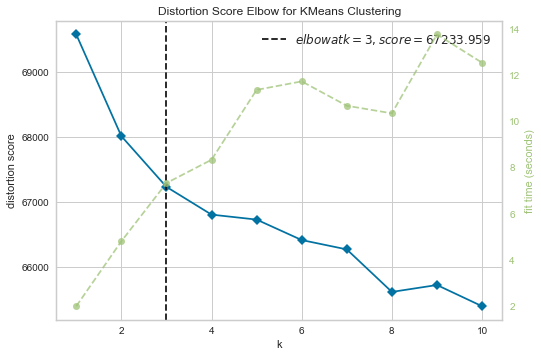

In [484]:
visualizer = KElbowVisualizer(kmeans, k=(1,11))
visualizer.fit(bow)
visualizer.show()

The `Silhouette` method is producing the score for each possible number of clusters we can use to group the words.

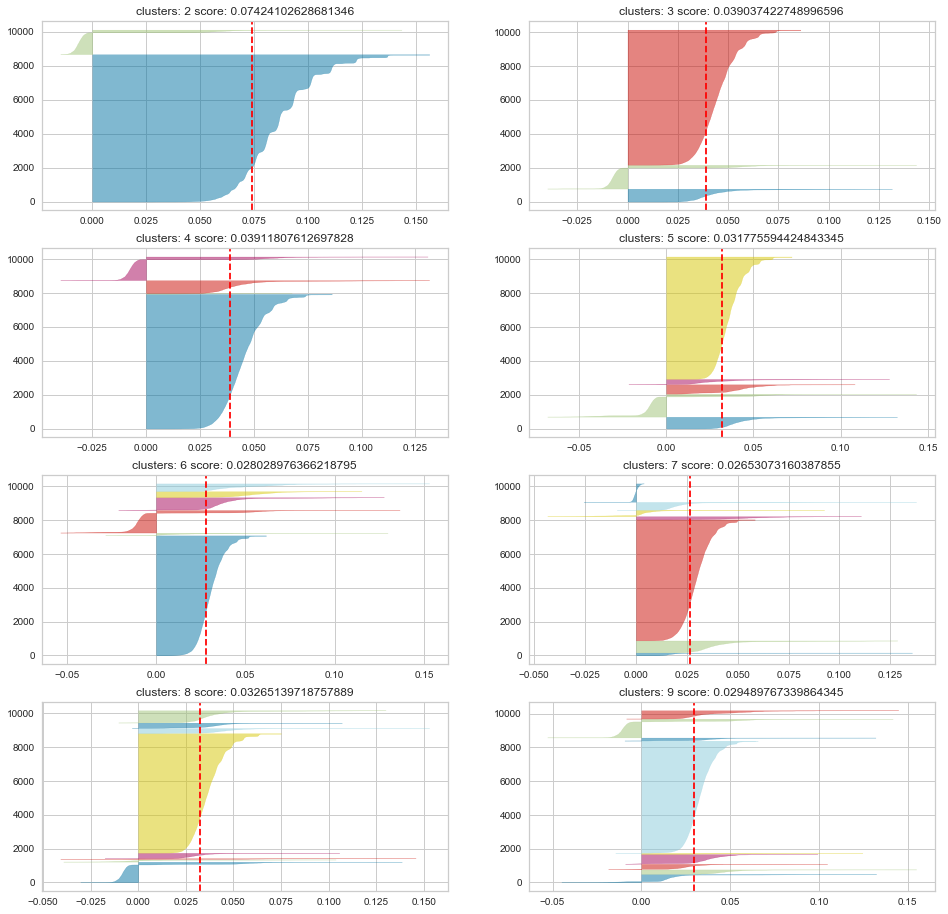

In [118]:
plt.figure(figsize=(4 * 4,  2 * 8))

scores = {}
for n_clusters in range(2, 10):
    plt.subplot(4,2, n_clusters - 1)
    kmeans = KMeans(n_clusters, random_state=42)
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    visualizer.fit(bow)
    scores[n_clusters] = visualizer.silhouette_score_
    plt.title(f'clusters: {n_clusters} score: {visualizer.silhouette_score_}')

The maximum score that *Silhouette* produced is 0.07 with 2 clusters. Beacause of the fact that the difference between the score of 2 clusters and the score of 3 clusters is relatively big, we choose 2 as the number of clusters we are going to use. 

In [119]:
sorted(scores.items(), key=lambda kv: kv[1], reverse=3)

[(2, 0.07424102628681346),
 (4, 0.03911807612697828),
 (3, 0.039037422748996596),
 (8, 0.03265139718757889),
 (5, 0.031775594424843345),
 (9, 0.029489767339864345),
 (6, 0.028028976366218795),
 (7, 0.02653073160387855)]

**Intercluster Distance** for the number of clusters we found before.

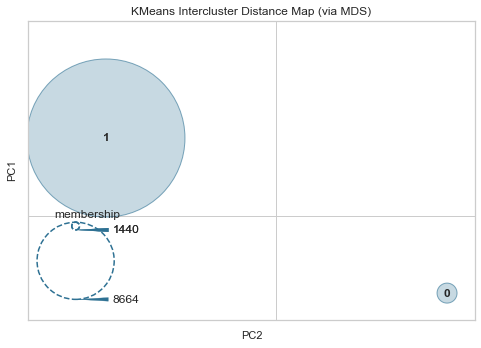

In [499]:
from yellowbrick.cluster import InterclusterDistance

model = KMeans(2)
visualizer = InterclusterDistance(model)
visualizer.fit(bow)
visualizer.show()

We find the top 10 features of each cluster's center.

In [513]:
kmeans = KMeans(n_clusters = 2, random_state=0)
kmeans.fit(bow)
arr = kmeans.cluster_centers_
centers = pd.DataFrame()
centers['cluster1_centers'] = arr[0]
centers['cluster2_centers'] = arr[1]
top_k = centers.sort_values(by=['cluster1_centers', 'cluster2_centers'], 
                            ascending=False).head(10).reset_index(drop=True)
top_k

,cluster1_centers,cluster2_centers
0,0.087027,0.040972
1,0.064751,0.059722
2,0.055171,0.050694
3,0.051939,0.059028
4,0.042244,0.065278
5,0.040743,0.043750
6,0.040282,0.043056
7,0.037627,0.040972
8,0.034280,0.046528
9,0.033934,0.034028


## 3. Classification </br>
In classification, our target variable (y) is the political party that the user, who posted the original text, is part of, while the training features (X) are the original texts we obtained before. We perform a groupby in order to get a picture of the total number of the groups' tweets.

In [246]:
clf_data = MEP_tweets[['origMepGroupShort', 'origTweetTxt']]
clf_data.groupby('origMepGroupShort').count()

,origTweetTxt
origMepGroupShort,
ALDE,1457
ECR,966
EFDD,2419
EPP,1638
GUE-NGL,304
Greens-EFA,953
S&D,2367


### Multinomial Naive Bayes Classifier

At first we are going to train the Multinomial NB Classifier, after applying a bag-of-words vectorizer (Count Vectorizer) and a Tfidf Transformer. Thus, we create a pipeline in order to easier execute it.

In [439]:
X_train, X_test, y_train, y_test = train_test_split(MEP_tweets.origTweetTxt, MEP_tweets.origMepGroupShort, 
                                                    test_size = .2, random_state=0, shuffle=True)
tweetsTxt_clf = Pipeline([('vect', CountVectorizer()),
                          ('tfidf', TfidfTransformer()),
                          ('clf', MultinomialNB())
                        ])
tweetsTxt_clf.fit(X_train, y_train)
predicted = tweetsTxt_clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

        ALDE       0.74      0.18      0.28       296
         ECR       1.00      0.03      0.05       180
        EFDD       0.48      0.93      0.63       473
         EPP       0.81      0.51      0.62       338
     GUE-NGL       0.00      0.00      0.00        64
  Greens-EFA       1.00      0.04      0.08       208
         S&D       0.43      0.74      0.54       462

    accuracy                           0.50      2021
   macro avg       0.64      0.35      0.32      2021
weighted avg       0.65      0.50      0.43      2021



In order to obtain better results, we need to find the values of parameters to pass into each activity of the pipeline. For this reason, we run grid search, which finds the best values for each parameter. 

In [386]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              #'vect__max_features': (None, 5000, 10000, 50000),
              'vect__strip_accents': ['ascii', 'unicode', None],
              'vect__decode_error': ['strict', 'ignore', 'replace'],
              'vect__stop_words': ['english', None],
              #'vect__analyzer': ['word', 'char', 'char_wb'],
              'tfidf__smooth_idf': [True, False],
              'tfidf__use_idf': (True, False),
              'tfidf__norm': ['l1', 'l2', None],
              'clf__alpha': (1e-2, 1e-3),
              #'clf__max_iter': (10, 50, 80)
             }
gs_clf = GridSearchCV(tweetsTxt_clf, parameters, n_jobs=-1, cv=5, verbose=10)
gs_clf = gs_clf.fit(X_train, y_train)
gs_clf.best_estimator_

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words='english', strip_accents='ascii',
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=False)),
                ('clf',
                 MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True))],
         verbose=False)

As we can see, if we pass the values to the parameters we want, we get better results. The accuracy was raised from 50% to 64%. It also brought better results on the political party of 'GUE-NGL' as the previous estimation was giving the impression that it had no idea for that party.

In [440]:
X_train, X_test, y_train, y_test = train_test_split(MEP_tweets.origTweetTxt, MEP_tweets.origMepGroupShort, 
                                                    test_size = .2, random_state=0, shuffle=True)
tweetsTxt_clf = Pipeline([('vect', CountVectorizer(analyzer='word', 
                                                   ngram_range=(1, 2),
                                                   input='content',
                                                   stop_words='english', 
                                                   decode_error='strict', 
                                                   strip_accents='ascii')),
                          ('tfidf', TfidfTransformer(norm='l2', use_idf=False)),
                          ('clf', MultinomialNB(alpha=0.01))
                        ])
tweetsTxt_clf.fit(X_train, y_train)
predicted = tweetsTxt_clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

        ALDE       0.55      0.56      0.56       296
         ECR       0.55      0.36      0.43       180
        EFDD       0.72      0.87      0.79       473
         EPP       0.68      0.66      0.67       338
     GUE-NGL       0.80      0.31      0.45        64
  Greens-EFA       0.63      0.36      0.46       208
         S&D       0.59      0.72      0.65       462

    accuracy                           0.64      2021
   macro avg       0.65      0.55      0.57      2021
weighted avg       0.64      0.64      0.63      2021



### Stochastic Gradient Descent Classifier
The second algorithm we are going to use is SGDClassifier. Without any relative effort it brings almost the same results, according to accuracy, as the previous one (Multinomial NB after Grid Search).

In [447]:
X_train, X_test, y_train, y_test = train_test_split(MEP_tweets.origTweetTxt, MEP_tweets.origMepGroupShort, 
                                                    test_size = 0.2, random_state=0)
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', random_state=0))
                    ])
text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
print(np.mean(predicted == y_test))
print(metrics.classification_report(y_test, predicted,
                                    target_names=y_test.unique()))

0.6397822859970311
              precision    recall  f1-score   support

        ALDE       0.58      0.55      0.57       296
        EFDD       0.56      0.38      0.45       180
         ECR       0.66      0.84      0.74       473
         EPP       0.70      0.65      0.67       338
  Greens-EFA       0.79      0.41      0.54        64
         S&D       0.58      0.41      0.48       208
     GUE-NGL       0.63      0.72      0.67       462

    accuracy                           0.64      2021
   macro avg       0.64      0.57      0.59      2021
weighted avg       0.64      0.64      0.63      2021



Our objective, again, is to bring better results, so we use Grid Search in order to find the optimal values for SGDClassifier's parameters. 

In [434]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              #'vect__max_features': (None, 5000, 10000, 50000),
              'vect__strip_accents': ['ascii', 'unicode', None],
              'vect__decode_error': ['strict', 'ignore', 'replace'],
              'vect__stop_words': ['english', None],
              #'vect__analyzer': ['word', 'char', 'char_wb'],
              #'tfidf__smooth_idf': [True, False],
              #'tfidf__use_idf': (True, False),
              #'tfidf__norm': ['l1', 'l2', None],
              'clf__alpha': (1e-2, 1e-3),
              'clf__penalty': ['l1', 'l2', None, 'elasticnet'],
              #'clf__shuffle': [True, False],
              #'clf__learning_rate': ['optimal', 'adaptive'],
              #'clf__eta0': (0.01, 0.001),
              #'clf__early_stopping': [True, False]
              #'clf__max_iter': (10, 50, 80)
             }
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, cv=5, verbose=10)
gs_clf = gs_clf.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words='english', strip_accents='ascii',
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabu...
                ('clf',
                 SGDClassifier(alpha=0.001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                      

In [437]:
gs_clf.best_params_

{'clf__alpha': 0.001,
 'clf__penalty': 'l2',
 'vect__decode_error': 'strict',
 'vect__ngram_range': (1, 2),
 'vect__stop_words': 'english',
 'vect__strip_accents': 'ascii'}

As far as we can see the results with the optimal values for each parameter do not differ significantly from the default analysis we did before. Maybe it is necessary to use cross-validation in order to split our data more effectively and avoid using the same sample to train and test.

In [438]:
X_train, X_test, y_train, y_test = train_test_split(MEP_tweets.origTweetTxt, MEP_tweets.origMepGroupShort, 
                                                    test_size = 0.2, random_state=0)
text_clf = Pipeline([('vect', CountVectorizer(decode_error='strict', 
                                 ngram_range=(1, 2),stop_words='english', strip_accents='ascii')),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(alpha = 0.001, penalty='l2'))
                    ])
text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
print(np.mean(predicted == y_test))
print(metrics.classification_report(y_test, predicted,
                                    target_names=y_test.unique()))

0.6348342404750124
              precision    recall  f1-score   support

        ALDE       0.66      0.53      0.59       296
        EFDD       0.64      0.28      0.39       180
         ECR       0.60      0.89      0.72       473
         EPP       0.68      0.70      0.69       338
  Greens-EFA       0.89      0.27      0.41        64
         S&D       0.73      0.34      0.47       208
     GUE-NGL       0.61      0.71      0.65       462

    accuracy                           0.63      2021
   macro avg       0.69      0.53      0.56      2021
weighted avg       0.65      0.63      0.62      2021



In [450]:
classifier = SGDClassifier(loss='hinge', random_state=0)
all_accuracies = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=5, scoring='accuracy')
print(all_accuracies)

C:\Users\nicko\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: could not convert string to float: "it is not the death penalty or hatred, @mlp_officiel but justice, that makes a people strong and free. c'est la france qui nous l'a appris"

In order to gauge the efficacy of the algorithms we used, we report the results of a classifier that uses very simple rules to analyze. This is *Dummy Classifier*. As far as we can see from DC's results, the previous classifiers are more accurate.

In [479]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=0)
dummy_clf.fit(X_train, y_train)
dummy_clf.predict(X_test)
dummy_clf.score(X_test, y_test)

0.23404255319148937